In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [3]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [4]:
sheet = pd.read_excel('data_input/PTA现货价格.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet['现货价：PTA（换）'].last_valid_index()

future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=30, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet[sheet.index <= target_end]

sheet.tail()

,现货价：PTA（换）
2025-12-01,NaN
2025-12-02,NaN
2025-12-03,NaN
2025-12-04,NaN
2025-12-05,NaN


In [5]:
# 尝试多个可能的文件路径
file_paths1 = [
    os.path.expanduser("~/Desktop/X-BASE/宏观经济/eta/USDCNY即期汇率_合并数据.xlsx"),
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/宏观经济/eta/USDCNY即期汇率_合并数据.xlsx")
]

file_path1 = None
for path in file_paths1:
    if os.path.isfile(path):  # 确保是文件而不是目录
        file_path1 = path
        break

if file_path1 is None:
    raise FileNotFoundError("未找到数据文件")

try:
    sheet1 = pd.ExcelFile(file_path1).parse('Sheet1')
    sheet1['Date'] = pd.to_datetime(sheet1['Date'], errors='coerce')
    #sheet1 = sheet1.drop(columns=['真实值'])
    sheet1 = sheet1.rename(columns={'预测值': 'USDCNY即期汇率_预测'})
    sheet1 = sheet1.rename(columns={'真实值': 'USDCNY即期汇率'})
    #sheet1 = sheet1.dropna()
    sheet1 = sheet1.sort_values('Date', ascending=True)
except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")

sheet1.head()

,Date,USDCNY即期汇率,USDCNY即期汇率_预测
766,2023-01-02,6.9205,NaN
765,2023-01-03,6.9050,NaN
764,2023-01-04,6.8825,NaN
763,2023-01-05,6.8731,NaN
762,2023-01-06,6.8588,NaN


In [6]:
# 尝试多个可能的文件路径
file_paths2 = [
    os.path.expanduser("~/Desktop/X-BASE/wti模型3.0/eta/wti_合并数据.xlsx"),
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/wti模型3.0/eta/wti_合并数据.xlsx")
]

file_path2 = None
for path in file_paths2:
    if os.path.isfile(path):  # 确保是文件而不是目录
        file_path2 = path
        break

if file_path2 is None:
    raise FileNotFoundError("未找到数据文件")

try:
    sheet2 = pd.ExcelFile(file_path2).parse('Sheet1')
    sheet2['Date'] = pd.to_datetime(sheet2['Date'], errors='coerce')
    #sheet2 = sheet2.drop(columns=['wti原油期货价格'])
    #sheet2 = sheet2.dropna()
    sheet2 = sheet2.sort_values('Date', ascending=True)
except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")

sheet2.head()

,Date,wti原油期货价格,WTI原油期货价格预测
729,2023-01-03,77.21,NaN
728,2023-01-04,73.22,NaN
727,2023-01-05,73.93,NaN
726,2023-01-06,73.73,NaN
725,2023-01-09,74.87,NaN


In [7]:
sheet3 = pd.read_excel('eta/PX-WTI价差_合并数据.xlsx', sheet_name='Sheet1')
sheet3['Date'] = pd.to_datetime(sheet3['Date'], errors='coerce')
sheet3 = sheet3.sort_values('Date', ascending=True) 
sheet3 = sheet3.rename(columns={'预测值': 'PX-WTI价差_预测'})
sheet3 = sheet3.rename(columns={'真实值': 'PX-WTI价差'})
sheet3.head()

,Date,PX-WTI价差,PX-WTI价差_预测
723,2023-01-03,402.4,NaN
722,2023-01-04,405.8,NaN
721,2023-01-05,407.6,NaN
720,2023-01-06,421.1,NaN
719,2023-01-09,414.8,NaN


In [8]:
sheet4 = pd.read_excel('eta/PTA加工费_合并数据.xlsx', sheet_name='Sheet1')
sheet4['Date'] = pd.to_datetime(sheet4['Date'], errors='coerce')
sheet4 = sheet4.sort_values('Date', ascending=True) 
sheet4 = sheet4.rename(columns={'预测值': 'PTA加工费_预测'})
sheet4 = sheet4.rename(columns={'真实值': 'PTA加工费'})
sheet4.head()

,Date,PTA加工费,PTA加工费_预测
697,2023-01-03,509.0,NaN
696,2023-01-04,561.4,NaN
695,2023-01-05,413.9,NaN
694,2023-01-06,373.4,NaN
693,2023-01-09,376.8,NaN


In [9]:
# 合并所有数据
merged_df = pd.merge(sheet, sheet1, how='outer', left_index=True, right_on='Date')
merged_df = pd.merge(merged_df, sheet2, how='outer', on='Date')
merged_df = pd.merge(merged_df, sheet3, how='outer', on='Date')
merged_df = pd.merge(merged_df, sheet4, how='outer', on='Date')
# 按日期排序
merged_df = merged_df.sort_values('Date')
# 将Date设为索引
merged_df = merged_df.set_index('Date')
# 过滤日期为2023年以后的数据
merged_df = merged_df[merged_df.index >= '2023-01-01']
# 显示结果
merged_df.head()

,现货价：PTA（换）,USDCNY即期汇率,USDCNY即期汇率_预测,wti原油期货价格,WTI原油期货价格预测,PX-WTI价差,PX-WTI价差_预测,PTA加工费,PTA加工费_预测
Date,,,,,,,,,
2023-01-02,NaN,6.9205,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-03,5609.09,6.9050,NaN,77.21,NaN,402.4,NaN,509.0,NaN
2023-01-04,5510.00,6.8825,NaN,73.22,NaN,405.8,NaN,561.4,NaN
2023-01-05,5395.00,6.8731,NaN,73.93,NaN,407.6,NaN,413.9,NaN
2023-01-06,5405.91,6.8588,NaN,73.73,NaN,421.1,NaN,373.4,NaN


In [10]:
cols_to_check = ['现货价：PTA（换）', 'USDCNY即期汇率', 'wti原油期货价格', 'PX-WTI价差','PTA加工费']
before_last_day = merged_df.loc[:last_day].dropna(subset=cols_to_check, how='any')  # 处理缺失值
after_last_day = merged_df.loc[last_day:]  # 保留 last 之后的数据

# 重新拼接数据
merged_df = pd.concat([before_last_day, after_last_day])
merged_df.head()

,现货价：PTA（换）,USDCNY即期汇率,USDCNY即期汇率_预测,wti原油期货价格,WTI原油期货价格预测,PX-WTI价差,PX-WTI价差_预测,PTA加工费,PTA加工费_预测
Date,,,,,,,,,
2023-01-03,5609.09,6.9050,NaN,77.21,NaN,402.4,NaN,509.0,NaN
2023-01-04,5510.00,6.8825,NaN,73.22,NaN,405.8,NaN,561.4,NaN
2023-01-05,5395.00,6.8731,NaN,73.93,NaN,407.6,NaN,413.9,NaN
2023-01-06,5405.91,6.8588,NaN,73.73,NaN,421.1,NaN,373.4,NaN
2023-01-09,5377.73,6.7712,NaN,74.87,NaN,414.8,NaN,376.8,NaN


In [11]:
merged_df['PTA现货价_历史值'] = merged_df['PTA加工费'] + (merged_df['PX-WTI价差'] + merged_df['wti原油期货价格']*7.5) * merged_df['USDCNY即期汇率'] *0.655
merged_df['PTA现货价_预测值'] = merged_df['PTA加工费_预测'] + (merged_df['PX-WTI价差_预测'] + merged_df['WTI原油期货价格预测']*7.5) * merged_df['USDCNY即期汇率_预测'] *0.655

In [12]:
merged_df.head()

,现货价：PTA（换）,USDCNY即期汇率,USDCNY即期汇率_预测,wti原油期货价格,WTI原油期货价格预测,PX-WTI价差,PX-WTI价差_预测,PTA加工费,PTA加工费_预测,PTA现货价_历史值,PTA现货价_预测值
Date,,,,,,,,,,,
2023-01-03,5609.09,6.9050,NaN,77.21,NaN,402.4,NaN,509.0,NaN,4947.990593,NaN
2023-01-04,5510.00,6.8825,NaN,73.22,NaN,405.8,NaN,561.4,NaN,4866.350411,NaN
2023-01-05,5395.00,6.8731,NaN,73.93,NaN,407.6,NaN,413.9,NaN,4745.046682,NaN
2023-01-06,5405.91,6.8588,NaN,73.73,NaN,421.1,NaN,373.4,NaN,4749.445575,NaN
2023-01-09,5377.73,6.7712,NaN,74.87,NaN,414.8,NaN,376.8,NaN,4706.934155,NaN


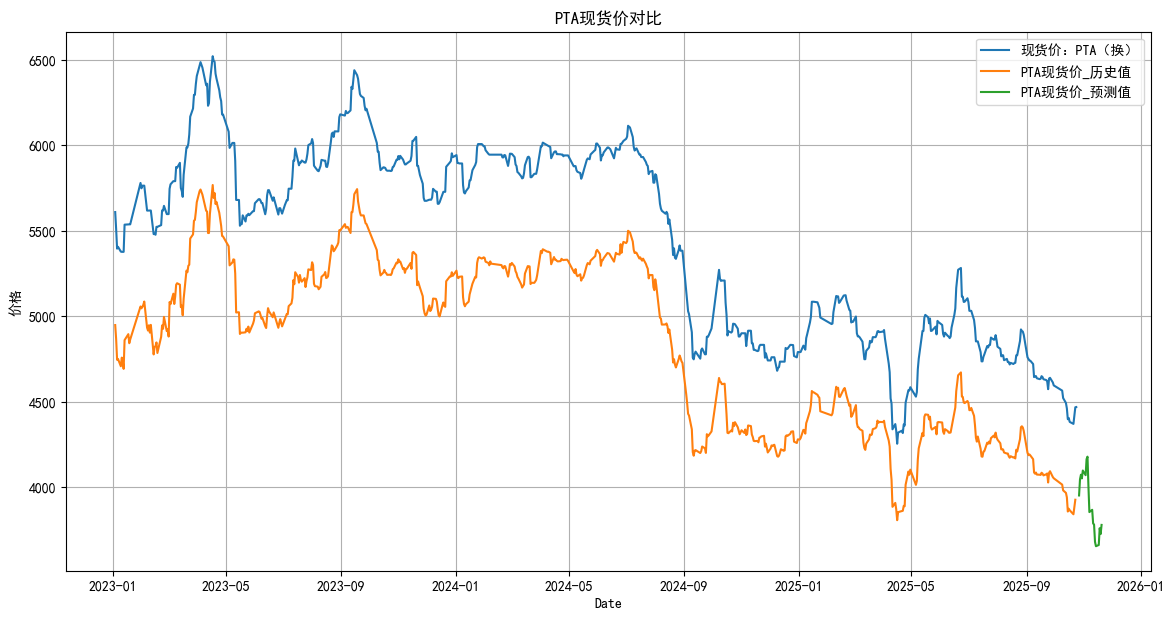

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(merged_df.index, merged_df['现货价：PTA（换）'], label='现货价：PTA（换）')
plt.plot(merged_df.index, merged_df['PTA现货价_历史值'], label='PTA现货价_历史值')
plt.plot(merged_df.index, merged_df['PTA现货价_预测值'], label='PTA现货价_预测值')

plt.xlabel('Date')
plt.ylabel('价格')
plt.title('PTA现货价对比')
plt.legend()
plt.grid(True)
plt.show()


In [14]:
merged_df_shizhi = merged_df.copy()
merged_df_shizhi = merged_df_shizhi.reset_index().rename(columns={'index': 'Date'})
merged_df_shizhi = merged_df_shizhi[['Date','PTA现货价_历史值','PTA现货价_预测值']]
merged_df_shizhi = merged_df_shizhi.dropna(subset=['PTA现货价_历史值', 'PTA现货价_预测值'], how='all')
merged_df_shizhi = merged_df_shizhi.sort_values('Date', ascending=False)
merged_df_shizhi['Date'] = merged_df_shizhi['Date'].dt.strftime('%Y/%m/%d')
merged_df_shizhi.to_excel('eta/PTA现货价_合并数据.xlsx', index=False,float_format='%.5f')
merged_df_shizhi.head()

,Date,PTA现货价_历史值,PTA现货价_预测值
660,2025/11/20,NaN,3778.781535
659,2025/11/19,NaN,3725.219653
658,2025/11/18,NaN,3759.430933
657,2025/11/17,NaN,3661.312770
656,2025/11/14,NaN,3654.096446


In [15]:
# 按月份重采样并取每月最后一个交易日的数据
monthly_df_shizhi = merged_df_shizhi.copy()
monthly_df_shizhi['Date'] = pd.to_datetime(monthly_df_shizhi['Date'])
monthly_df_shizhi = monthly_df_shizhi.set_index('Date')
monthly_df_shizhi = monthly_df_shizhi.resample('ME').last()
monthly_df_shizhi = monthly_df_shizhi.reset_index()
monthly_df_shizhi = monthly_df_shizhi.sort_values('Date', ascending=False)
monthly_df_shizhi['Date'] = monthly_df_shizhi['Date'].dt.strftime('%Y/%m/%d')
monthly_df_shizhi.to_excel('eta/PTA现货价_月度数据.xlsx', index=False, float_format='%.2f')
monthly_df_shizhi.head()


,Date,PTA现货价_历史值,PTA现货价_预测值
34,2025/11/30,NaN,3778.781535
33,2025/10/31,3926.089431,4097.001092
32,2025/09/30,4051.678115,NaN
31,2025/08/31,4328.710270,NaN
30,2025/07/31,4291.596163,NaN


In [16]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.化工_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "PTA现货价"

# 调用函数更新数据
success = update_excel_data(merged_df_shizhi, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [17]:
from Lcel import update_excel_data
file_path = "eta/1.化工_数据上传.xlsx"
sheet_name = "详情页"
identifier = "PTA现货价"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(monthly_df_shizhi, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

数据过滤完成: 保留 23 条数据（2024/01/31 之后），按时间倒序排列
已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/10/31, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件
